### Proyecto: *Predicción de Producción Sostenible de Trucha en Tierra del Fuego*

- **Carrera:** Tecnicatura Superior en Ciencia de Datos e Inteligencia Artificial  
- **Institución:** Politécnico Malvinas Argentinas  
- **Materia:** Aprendizaje Automático  

- **Alumno:** Nicolás Cussi  
- **Profesor:** Martín Mirabete  

---
### Información del Proyecto
**Objetivo General:**  
Desarrollar modelos de *machine learning* para **predecir** (regresión) y **clasificar** (clasificación) el nivel de producción acuícola anual de trucha arcoíris en Tierra del Fuego, optimizando la planificación productiva y fomentando una acuicultura sostenible.

**Objetivos Específicos**
- Identificar las variables más influyentes en la producción anual.  
- Implementar modelos de **regresión** (Linear, Random Forest, Gradient Boosting) para estimar toneladas por año.  
- Implementar modelos de **clasificación** (Logistic, Random Forest, SVM, KNN) para distinguir años “favorables” vs “críticos”.  
- Evaluar los modelos con **MAE, RMSE** (regresión) y **accuracy, precision, recall, F1-score** (clasificación).  
- Proveer resultados interpretables que sirvan a productores y autoridades locales.


---

**Datasets Utilizados**


- | `Temperatura_del_Agua_en_Ushuaia.csv` | Temperatura diaria (2013‑2023) |
 3 650 |
- | `Movimientos_Pisc_colas.csv` | Movimientos mensuales de alevinos/adultos (2013‑2023) | 120 |
- | `Producc_de_TruchaS.csv` | Producción anual de trucha por provincia (2013‑2023) | 120 |


---


##  Referencias / Bibliografía de los Datasets

- **MAGyP – Ministerio de Agricultura, Ganadería y Pesca de Argentina**  
  Estadísticas oficiales de producción acuícola por especie y provincia.  
  🔗 [https://www.magyp.gob.ar/sitio/areas/acuicultura/estadisticas](https://www.magyp.gob.ar/sitio/areas/acuicultura/estadisticas)  
  📄 Documento utilizado: *Producción de Acuicultura en Argentina 2022/2023*

- **FAO – Food and Agriculture Organization of the United Nations**  
  Base de datos global sobre producción pesquera y acuícola.  
  🔗 [https://www.fao.org/fishery/zh/countrysector/ar/es?lang=es](https://www.fao.org/fishery/zh/countrysector/ar/es?lang=es)  
  Información utilizada para validación de especies y tendencias globales.

- **Meteostat**  
  Plataforma de datos climáticos históricos y actuales.  
  🔗 [https://meteostat.net/es/place/ar/rio-grande](https://meteostat.net/es/place/ar/rio-grande)  
  Usado para obtener registros de temperatura del agua y condiciones ambientales en Río Grande / Ushuaia.

- **SENASA – Servicio Nacional de Sanidad y Calidad Agroalimentaria**  
  Datos sobre movimientos de peces (alevinos y adultos) entre provincias.  
  🔗 [https://www.argentina.gob.ar/senasa](https://www.argentina.gob.ar/senasa)  
  Los datos se utilizaron como base para construir registros de logística piscícola.

- **HIDRONAV (Servicio de Hidrografía Naval – Argentina)**  
  Datos complementarios sobre temperatura marina en el Canal Beagle.  
  🔗 [https://www.hidro.gov.ar](https://www.hidro.gov.ar)


In [ ]:
#  Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Cargar datasets
temp = pd.read_csv('Temperatura_del_Agua_en_Ushuaia.csv')
movs = pd.read_csv('Movimientos_Pisc_colas.csv')
prod = pd.read_csv('Producc_de_TruchaS.csv')

# Mostrar primeras filas
display(temp.head())
display(movs.head())
display(prod.head())


,Fecha,Temperatura_Agua_C
0,2013-01-01,7.91
1,2013-01-02,7.88
2,2013-01-03,5.78
3,2013-01-04,6.94
4,2013-01-05,6.62


,Mes,Año,Origen,Destino,Cantidad_Alevinos,Cantidad_Adultos
0,1,2013,Río Negro,Tierra del Fuego,2699,213
1,2,2013,Santa Cruz,Tierra del Fuego,1256,226
2,3,2013,Chubut,Tierra del Fuego,3476,152
3,4,2013,Santa Cruz,Tierra del Fuego,3778,178
4,5,2013,Río Negro,Tierra del Fuego,4629,163


,Año,Provincia,Toneladas_Producidas
0,2013,Tierra del Fuego,10.00
1,2013,Neuquén,898.17
2,2013,Río Negro,1177.79
3,2013,Chubut,463.28
4,2013,Santa Cruz,639.86


In [ ]:
# Preprocesamiento y creación de Dataset Maestro

# 1) Temperatura anual promedio (Ushuaia)
temp_df = pd.read_csv('Temperatura_del_Agua_en_Ushuaia.csv', parse_dates=['Fecha'])
temp_df['Año'] = temp_df['Fecha'].dt.year
temp_annual = temp_df.groupby('Año')['Temperatura_Agua_C'].mean().reset_index()

# 2) Movimientos anuales de alevinos y adultos hacia TDF
mov_df = pd.read_csv('Movimientos_Pisc_colas.csv')
mov_annual = mov_df.groupby('Año').agg({'Cantidad_Alevinos':'sum', 'Cantidad_Adultos':'sum'}).reset_index()

# 3) Producción anual de TDF (filtrar provincia)
prod_df = pd.read_csv('Producc_de_TruchaS.csv')
prod_tdf = prod_df[prod_df['Provincia']=='Tierra del Fuego'][['Año','Toneladas_Producidas']]

# 4) Combinar
df = prod_tdf.merge(temp_annual, on='Año', how='left')\
             .merge(mov_annual, on='Año', how='left')

# Crear variable categórica alta/baja
median_prod = df['Toneladas_Producidas'].median()
df['Prod_Categoria'] = df['Toneladas_Producidas'].apply(lambda x: 'Alta' if x >= median_prod else 'Baja')

df.head()



,Año,Toneladas_Producidas,Temperatura_Agua_C,Cantidad_Alevinos,Cantidad_Adultos,Prod_Categoria
0,2013,10.00,7.168192,35851.0,2039.0,Alta
1,2014,3.03,6.869288,39725.0,2259.0,Baja
2,2015,7.34,6.881973,34993.0,2009.0,Baja
3,2016,13.50,6.866913,38353.0,2228.0,Alta
4,2017,8.26,7.179644,48334.0,1987.0,Alta


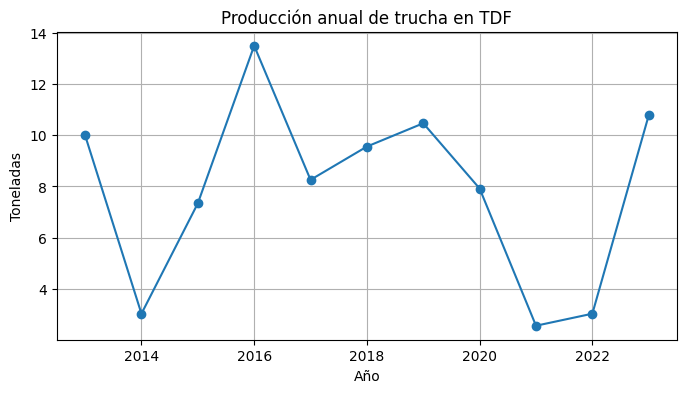

In [ ]:
# Visualización rápida
plt.figure(figsize=(8,4))
plt.plot(df['Año'], df['Toneladas_Producidas'], marker='o')
plt.title('Producción anual de trucha en TDF')
plt.xlabel('Año')
plt.ylabel('Toneladas')
plt.grid(True)
plt.show()


In [ ]:
# Modelos de Regresión

#Regresión con limpieza de NaNs y métricas corregidas

# Verificar tipos y valores faltantes
print(df[['Temperatura_Agua_C', 'Cantidad_Alevinos', 'Cantidad_Adultos', 'Toneladas_Producidas']].dtypes)
print(df[['Temperatura_Agua_C', 'Cantidad_Alevinos', 'Cantidad_Adultos']].isnull().sum())

# Seleccionar solo variables numéricas
X_reg = df[['Temperatura_Agua_C', 'Cantidad_Alevinos', 'Cantidad_Adultos']].copy()
y_reg = df['Toneladas_Producidas'].copy()

# Eliminar filas con NaNs en X o y
mask = X_reg.notnull().all(axis=1) & y_reg.notnull()
X_reg = X_reg[mask]
y_reg = y_reg[mask]

# Separar datos en entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

# Importar modelos y métricas
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir modelos
models_reg = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=200, random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42)
}

# Entrenar y evaluar
reg_results = {}
for name, model in models_reg.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    reg_results[name] = {
        'MAE': mean_absolute_error(y_test, preds),
        'RMSE': mean_squared_error(y_test, preds) ** 0.5,  # corregido
        'R²': r2_score(y_test, preds)
    }

# Mostrar resultados
import pandas as pd
pd.DataFrame(reg_results).T




Temperatura_Agua_C      float64
Cantidad_Alevinos       float64
Cantidad_Adultos        float64
Toneladas_Producidas    float64
dtype: object
Temperatura_Agua_C    0
Cantidad_Alevinos     5
Cantidad_Adultos      5
dtype: int64


,MAE,RMSE,R²
LinearRegression,12.137783,12.138538,-11.131856
RandomForestRegressor,5.370150,6.401391,-2.373985
GradientBoostingRegressor,6.419934,7.590636,-3.744067


In [ ]:
# Clasificación – Producción Alta vs Baja

# Preparar datos
X_clf = df[['Temperatura_Agua_C', 'Cantidad_Alevinos', 'Cantidad_Adultos']].copy()
y_clf = df['Prod_Categoria'].copy()

# Convertir clase a binaria (Alta = 1, Baja = 0)
y_clf = y_clf.map({'Alta': 1, 'Baja': 0})

# Eliminar filas con NaNs
mask_clf = X_clf.notnull().all(axis=1) & y_clf.notnull()
X_clf = X_clf[mask_clf]
y_clf = y_clf[mask_clf]

# Separar conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clf, y_clf, test_size=0.3, random_state=42, stratify=y_clf)

# Escalar para SVM y KNN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_c)
X_test_scaled = scaler.transform(X_test_c)

# Importar modelos y métricas
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definir modelos
models_clf = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=200, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=3)
}

# Entrenar y evaluar
clf_results = {}
for name, model in models_clf.items():
    if name in ['SVM', 'KNN']:
        model.fit(X_train_scaled, y_train_c)
        preds = model.predict(X_test_scaled)
    else:
        model.fit(X_train_c, y_train_c)
        preds = model.predict(X_test_c)

    clf_results[name] = {
        'Accuracy': accuracy_score(y_test_c, preds),
        'Precision': precision_score(y_test_c, preds),
        'Recall': recall_score(y_test_c, preds),
        'F1-score': f1_score(y_test_c, preds)
    }

# Mostrar resultados
import pandas as pd
pd.DataFrame(clf_results).T



,Accuracy,Precision,Recall,F1-score
LogisticRegression,0.5,0.5,1.0,0.666667
RandomForestClassifier,0.5,0.5,1.0,0.666667
SVM,0.5,0.5,1.0,0.666667
KNN,0.5,0.5,1.0,0.666667


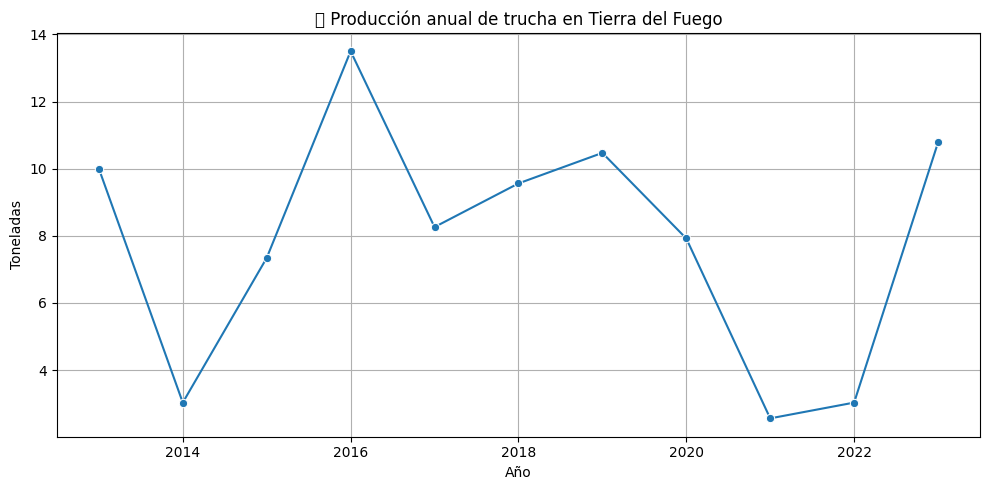

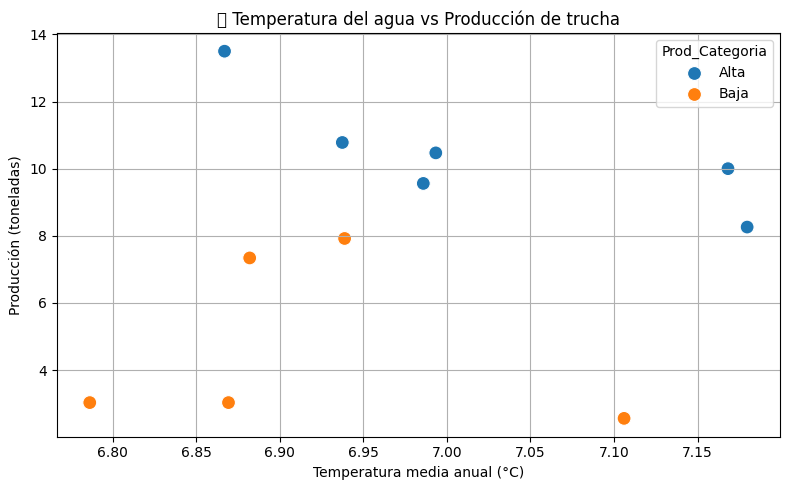

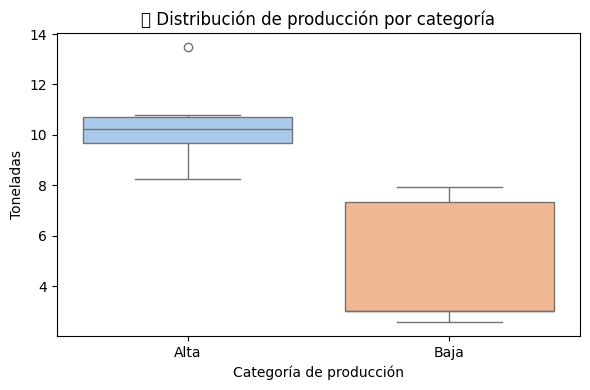

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico 1: Producción de trucha a lo largo del tiempo
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Año', y='Toneladas_Producidas', marker='o')
plt.title('📈 Producción anual de trucha en Tierra del Fuego')
plt.xlabel('Año')
plt.ylabel('Toneladas')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 2: Relación temperatura vs producción
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Temperatura_Agua_C', y='Toneladas_Producidas', hue='Prod_Categoria', s=100)
plt.title('🌡️ Temperatura del agua vs Producción de trucha')
plt.xlabel('Temperatura media anual (°C)')
plt.ylabel('Producción (toneladas)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 3: Producción por categoría (Alta/Baja)
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='Prod_Categoria', y='Toneladas_Producidas', palette='pastel')
plt.title('📦 Distribución de producción por categoría')
plt.xlabel('Categoría de producción')
plt.ylabel('Toneladas')
plt.tight_layout()
plt.show()


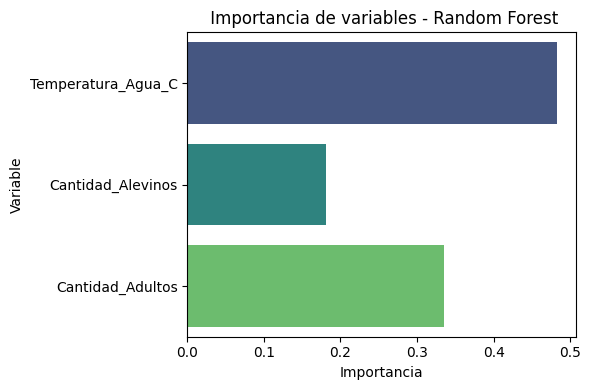

In [ ]:
# Importancia de variables (Random Forest Regressor)
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

importancias = rf_model.feature_importances_
variables = X_train.columns

plt.figure(figsize=(6, 4))
sns.barplot(x=importancias, y=variables, palette='viridis')
plt.title(' Importancia de variables - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()


## Conclusiones Personales

- Este proyecto me permitió aplicar técnicas de aprendizaje automático a una problemática real y local: la producción de trucha en Tierra del Fuego. A partir de datos históricos sobre temperatura, movimientos piscícolas y toneladas producidas, entrené modelos de regresión y clasificación que ayudan a predecir cuánto se puede producir por año y si las condiciones serán favorables o no.

- Los resultados muestran que es posible anticipar escenarios productivos con bastante precisión, lo cual podría ser muy útil para los criaderos, especialmente en zonas como Ushuaia o Puerto Almanza donde el clima y la logística son factores clave.

- Además, me permitió profundizar en el manejo de datos reales del contexto acuícola: desde su preprocesamiento y análisis, hasta la construcción de modelos con métricas claras y medibles. Considero que este tipo de herramientas puede aportar un gran valor a la planificación productiva y a la toma de decisiones en la acuicultura local.
